### Problem2: implement a classification network (e.g., ResNet50) to classify the skin diseases

In [92]:
import random
import shutil
import time
import warnings
import sys
import torch
import os
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torch.nn.init as init
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
"""Dataset.

    Customize your dataset here.
"""

import os

import PIL.Image
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

from torchvision import transforms


class Skin7(Dataset):
    """SKin Lesion"""
    def __init__(self, root="./datas", train=True,transform=None):
        self.root = os.path.join(root)
        #labels
        
        self.train = train
        self.data = pd.read_csv(root+"/annotation/train.csv") if train else pd.read_csv(root+"/annotation/test.csv")
        self.data["image_train"] = root + '/images/' + self.data["image_train"]
        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.data.iloc[index]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

    def __len__(self):
        return len(self.data)


In [95]:
train_transform = transforms.Compose([transforms.RandomRotation(35),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(200),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

trainset = Skin7(train=True, transform=train_transform)
testset = Skin7(train=False, transform=test_transform)

In [96]:
#params
batch_size = 24

In [97]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, pin_memory=True)

In [98]:
size = len(trainloader.dataset)
print(size)

305


In [99]:
print(len(trainloader))

13


In [100]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out



def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)



model_dict = {
    'resnet50': [resnet50, 2048]
}


class LinearBatchNorm(nn.Module):
    """Implements BatchNorm1d by BatchNorm2d, for SyncBN purpose"""
    def __init__(self, dim, affine=True):
        super(LinearBatchNorm, self).__init__()
        self.dim = dim
        self.bn = nn.BatchNorm2d(dim, affine=affine)

    def forward(self, x):
        x = x.view(-1, self.dim, 1, 1)
        x = self.bn(x)
        x = x.view(-1, self.dim)
        return x


class RNet50(nn.Module):
    def __init__(self, name='resnet50', head='linear', feat_dim=7):
        super(RNet50, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat

In [101]:
from torchvision.models import resnet

resnet.model_urls["resnet50"] = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"
   
  # Initialize the model using the legacy API
model = resnet.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 7)
)
model = model.to(device)
#print(model)

In [102]:
#loss
criterion = nn.CrossEntropyLoss().to(device)

In [103]:
# Optmizer
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      weight_decay=1e-4)

In [104]:
#train
Max_epoch = 60
def train(model, trainloader,loss_func,optimizer,epoch):
    model = model.to(device)
    model.train()
    size = len(trainloader.dataset)
    num_batches = len(trainset)
    losses = []
    scores = []
    N_count = 0     
    for batch_idx, (X, y) in tqdm(enumerate(trainloader)):
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        N_count += X.size(0)
        output = model(X)
        loss = loss_func(output, y)
        losses.append(loss.item())
        
        pred = torch.argmax(output, dim=1)

        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), pred.cpu().data.squeeze().numpy())
        scores.append(step_score)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Acc: {:.2f}%'.format(
        epoch + 1,N_count, len(trainloader.dataset), 100. * (batch_idx + 1) / len(trainloader), loss.item(), 100 * step_score))    
            
    return losses, scores

In [105]:
def test(model,testloader,loss_func):
    # test mode
    model.eval()
    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for _, (data, target) in enumerate(testloader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_func(output, target)
            test_loss += loss.item()
        
            y_pred = torch.argmax(output, dim=1)
        
            all_y.extend(target)
            all_y_pred.extend(y_pred)

        test_loss /= len(testloader.dataset)
        all_y = torch.stack(all_y, dim=0)
        all_y_pred = torch.stack(all_y_pred, dim=0)
        test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

        print('\nTest set: loss: {:.4f}, Accuracy: {:.2f}%\n'.format(test_loss, 100* test_score))

        return test_loss, test_score




In [106]:
train_Acc_list = []
train_loss_list = []
test_Acc_list = []
test_loss_list = []

for epoch in range(Max_epoch):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_losses, train_scores = train(model, trainloader,criterion,optimizer,epoch)
    epoch_test_loss, epoch_test_score = test(model,testloader,criterion)
    
    train_Acc_list.append(train_scores)
    train_loss_list.append(train_losses)
    test_Acc_list.append(epoch_test_score)
    test_loss_list.append(epoch_test_loss)

print("Done!")

Epoch 1
-------------------------------


13it [01:22,  6.34s/it]


Train Epoch: 1 [305/305 (100%)]	Loss: 1.523084, Acc: 58.82%

Test set: loss: 0.0818, Accuracy: 67.68%

Epoch 2
-------------------------------


13it [01:21,  6.24s/it]


Train Epoch: 2 [305/305 (100%)]	Loss: 0.921315, Acc: 76.47%

Test set: loss: 0.0629, Accuracy: 67.68%

Epoch 3
-------------------------------


13it [01:20,  6.22s/it]


Train Epoch: 3 [305/305 (100%)]	Loss: 1.362404, Acc: 52.94%

Test set: loss: 0.0520, Accuracy: 67.68%

Epoch 4
-------------------------------


13it [01:22,  6.34s/it]


Train Epoch: 4 [305/305 (100%)]	Loss: 0.974711, Acc: 70.59%

Test set: loss: 0.0537, Accuracy: 67.68%

Epoch 5
-------------------------------


13it [01:21,  6.28s/it]


Train Epoch: 5 [305/305 (100%)]	Loss: 0.584226, Acc: 88.24%

Test set: loss: 0.0539, Accuracy: 67.68%

Epoch 6
-------------------------------


13it [01:21,  6.30s/it]


Train Epoch: 6 [305/305 (100%)]	Loss: 0.585348, Acc: 76.47%

Test set: loss: 0.0520, Accuracy: 67.68%

Epoch 7
-------------------------------


13it [01:22,  6.35s/it]


Train Epoch: 7 [305/305 (100%)]	Loss: 0.703030, Acc: 70.59%

Test set: loss: 0.0498, Accuracy: 67.68%

Epoch 8
-------------------------------


13it [01:20,  6.22s/it]


Train Epoch: 8 [305/305 (100%)]	Loss: 0.842180, Acc: 70.59%

Test set: loss: 0.0517, Accuracy: 67.68%

Epoch 9
-------------------------------


13it [01:22,  6.32s/it]


Train Epoch: 9 [305/305 (100%)]	Loss: 0.780593, Acc: 70.59%

Test set: loss: 0.0477, Accuracy: 67.68%

Epoch 10
-------------------------------


13it [01:15,  5.83s/it]


Train Epoch: 10 [305/305 (100%)]	Loss: 0.902276, Acc: 64.71%

Test set: loss: 0.0488, Accuracy: 69.70%

Epoch 11
-------------------------------


13it [00:51,  3.94s/it]


Train Epoch: 11 [305/305 (100%)]	Loss: 0.530129, Acc: 82.35%

Test set: loss: 0.0484, Accuracy: 68.69%

Epoch 12
-------------------------------


13it [00:51,  3.94s/it]


Train Epoch: 12 [305/305 (100%)]	Loss: 0.672044, Acc: 76.47%

Test set: loss: 0.0472, Accuracy: 71.72%

Epoch 13
-------------------------------


13it [00:51,  3.95s/it]


Train Epoch: 13 [305/305 (100%)]	Loss: 0.599701, Acc: 82.35%

Test set: loss: 0.0476, Accuracy: 68.69%

Epoch 14
-------------------------------


13it [00:50,  3.92s/it]


Train Epoch: 14 [305/305 (100%)]	Loss: 1.215222, Acc: 58.82%

Test set: loss: 0.0463, Accuracy: 67.68%

Epoch 15
-------------------------------


13it [00:50,  3.91s/it]


Train Epoch: 15 [305/305 (100%)]	Loss: 0.742370, Acc: 70.59%

Test set: loss: 0.0457, Accuracy: 69.70%

Epoch 16
-------------------------------


13it [00:51,  3.96s/it]


Train Epoch: 16 [305/305 (100%)]	Loss: 0.516678, Acc: 88.24%

Test set: loss: 0.0457, Accuracy: 71.72%

Epoch 17
-------------------------------


13it [00:50,  3.86s/it]


Train Epoch: 17 [305/305 (100%)]	Loss: 0.475962, Acc: 88.24%

Test set: loss: 0.0456, Accuracy: 71.72%

Epoch 18
-------------------------------


13it [00:51,  3.95s/it]


Train Epoch: 18 [305/305 (100%)]	Loss: 0.493133, Acc: 88.24%

Test set: loss: 0.0453, Accuracy: 69.70%

Epoch 19
-------------------------------


13it [00:51,  3.96s/it]


Train Epoch: 19 [305/305 (100%)]	Loss: 0.522040, Acc: 82.35%

Test set: loss: 0.0430, Accuracy: 70.71%

Epoch 20
-------------------------------


13it [00:51,  3.92s/it]


Train Epoch: 20 [305/305 (100%)]	Loss: 0.397326, Acc: 94.12%

Test set: loss: 0.0402, Accuracy: 69.70%

Epoch 21
-------------------------------


13it [00:51,  3.93s/it]


Train Epoch: 21 [305/305 (100%)]	Loss: 0.546160, Acc: 82.35%

Test set: loss: 0.0420, Accuracy: 71.72%

Epoch 22
-------------------------------


13it [00:50,  3.87s/it]


Train Epoch: 22 [305/305 (100%)]	Loss: 0.853743, Acc: 64.71%

Test set: loss: 0.0411, Accuracy: 73.74%

Epoch 23
-------------------------------


13it [00:51,  3.96s/it]


Train Epoch: 23 [305/305 (100%)]	Loss: 0.449732, Acc: 88.24%

Test set: loss: 0.0431, Accuracy: 76.77%

Epoch 24
-------------------------------


13it [00:50,  3.91s/it]


Train Epoch: 24 [305/305 (100%)]	Loss: 0.274066, Acc: 100.00%

Test set: loss: 0.0403, Accuracy: 73.74%

Epoch 25
-------------------------------


13it [00:51,  3.96s/it]


Train Epoch: 25 [305/305 (100%)]	Loss: 1.154032, Acc: 70.59%

Test set: loss: 0.0393, Accuracy: 73.74%

Epoch 26
-------------------------------


13it [00:51,  3.94s/it]


Train Epoch: 26 [305/305 (100%)]	Loss: 0.739543, Acc: 76.47%

Test set: loss: 0.0427, Accuracy: 73.74%

Epoch 27
-------------------------------


13it [00:51,  3.93s/it]


Train Epoch: 27 [305/305 (100%)]	Loss: 0.695864, Acc: 76.47%

Test set: loss: 0.0419, Accuracy: 70.71%

Epoch 28
-------------------------------


13it [00:52,  4.01s/it]


Train Epoch: 28 [305/305 (100%)]	Loss: 0.647543, Acc: 64.71%

Test set: loss: 0.0395, Accuracy: 72.73%

Epoch 29
-------------------------------


13it [00:52,  4.00s/it]


Train Epoch: 29 [305/305 (100%)]	Loss: 0.708207, Acc: 76.47%

Test set: loss: 0.0389, Accuracy: 73.74%

Epoch 30
-------------------------------


13it [00:53,  4.10s/it]


Train Epoch: 30 [305/305 (100%)]	Loss: 0.374791, Acc: 94.12%

Test set: loss: 0.0390, Accuracy: 74.75%

Epoch 31
-------------------------------


13it [00:53,  4.14s/it]


Train Epoch: 31 [305/305 (100%)]	Loss: 0.241562, Acc: 94.12%

Test set: loss: 0.0441, Accuracy: 69.70%

Epoch 32
-------------------------------


13it [00:51,  3.99s/it]


Train Epoch: 32 [305/305 (100%)]	Loss: 0.338804, Acc: 100.00%

Test set: loss: 0.0442, Accuracy: 70.71%

Epoch 33
-------------------------------


13it [00:54,  4.23s/it]


Train Epoch: 33 [305/305 (100%)]	Loss: 0.546718, Acc: 76.47%

Test set: loss: 0.0406, Accuracy: 71.72%

Epoch 34
-------------------------------


13it [00:53,  4.13s/it]


Train Epoch: 34 [305/305 (100%)]	Loss: 0.205274, Acc: 100.00%

Test set: loss: 0.0382, Accuracy: 73.74%

Epoch 35
-------------------------------


13it [00:53,  4.10s/it]


Train Epoch: 35 [305/305 (100%)]	Loss: 0.251521, Acc: 88.24%

Test set: loss: 0.0392, Accuracy: 73.74%

Epoch 36
-------------------------------


13it [00:52,  4.06s/it]


Train Epoch: 36 [305/305 (100%)]	Loss: 0.448743, Acc: 82.35%

Test set: loss: 0.0385, Accuracy: 75.76%

Epoch 37
-------------------------------


13it [00:51,  3.97s/it]


Train Epoch: 37 [305/305 (100%)]	Loss: 0.440766, Acc: 88.24%

Test set: loss: 0.0403, Accuracy: 74.75%

Epoch 38
-------------------------------


13it [00:52,  4.02s/it]


Train Epoch: 38 [305/305 (100%)]	Loss: 0.696985, Acc: 70.59%

Test set: loss: 0.0393, Accuracy: 72.73%

Epoch 39
-------------------------------


13it [00:51,  3.97s/it]


Train Epoch: 39 [305/305 (100%)]	Loss: 0.609339, Acc: 76.47%

Test set: loss: 0.0406, Accuracy: 73.74%

Epoch 40
-------------------------------


13it [00:51,  4.00s/it]


Train Epoch: 40 [305/305 (100%)]	Loss: 0.403888, Acc: 88.24%

Test set: loss: 0.0408, Accuracy: 75.76%

Epoch 41
-------------------------------


13it [00:51,  3.93s/it]


Train Epoch: 41 [305/305 (100%)]	Loss: 0.534300, Acc: 88.24%

Test set: loss: 0.0411, Accuracy: 73.74%

Epoch 42
-------------------------------


13it [00:51,  4.00s/it]


Train Epoch: 42 [305/305 (100%)]	Loss: 0.761309, Acc: 76.47%

Test set: loss: 0.0376, Accuracy: 73.74%

Epoch 43
-------------------------------


13it [00:53,  4.08s/it]


Train Epoch: 43 [305/305 (100%)]	Loss: 0.491637, Acc: 82.35%

Test set: loss: 0.0371, Accuracy: 71.72%

Epoch 44
-------------------------------


13it [00:51,  3.95s/it]


Train Epoch: 44 [305/305 (100%)]	Loss: 0.669992, Acc: 76.47%

Test set: loss: 0.0362, Accuracy: 73.74%

Epoch 45
-------------------------------


13it [00:51,  4.00s/it]


Train Epoch: 45 [305/305 (100%)]	Loss: 0.411416, Acc: 88.24%

Test set: loss: 0.0338, Accuracy: 73.74%

Epoch 46
-------------------------------


13it [00:53,  4.10s/it]


Train Epoch: 46 [305/305 (100%)]	Loss: 0.503368, Acc: 82.35%

Test set: loss: 0.0343, Accuracy: 71.72%

Epoch 47
-------------------------------


13it [00:53,  4.15s/it]


Train Epoch: 47 [305/305 (100%)]	Loss: 0.717476, Acc: 70.59%

Test set: loss: 0.0348, Accuracy: 73.74%

Epoch 48
-------------------------------


13it [00:52,  4.03s/it]


Train Epoch: 48 [305/305 (100%)]	Loss: 0.617709, Acc: 70.59%

Test set: loss: 0.0380, Accuracy: 70.71%

Epoch 49
-------------------------------


13it [00:52,  4.02s/it]


Train Epoch: 49 [305/305 (100%)]	Loss: 0.315747, Acc: 82.35%

Test set: loss: 0.0373, Accuracy: 69.70%

Epoch 50
-------------------------------


13it [00:51,  3.94s/it]


Train Epoch: 50 [305/305 (100%)]	Loss: 0.453992, Acc: 82.35%

Test set: loss: 0.0386, Accuracy: 69.70%

Epoch 51
-------------------------------


13it [00:51,  3.99s/it]


Train Epoch: 51 [305/305 (100%)]	Loss: 0.548981, Acc: 76.47%

Test set: loss: 0.0373, Accuracy: 74.75%

Epoch 52
-------------------------------


13it [00:51,  3.97s/it]


Train Epoch: 52 [305/305 (100%)]	Loss: 0.585074, Acc: 70.59%

Test set: loss: 0.0400, Accuracy: 71.72%

Epoch 53
-------------------------------


13it [00:51,  3.93s/it]


Train Epoch: 53 [305/305 (100%)]	Loss: 0.200677, Acc: 94.12%

Test set: loss: 0.0415, Accuracy: 67.68%

Epoch 54
-------------------------------


13it [00:51,  3.93s/it]


Train Epoch: 54 [305/305 (100%)]	Loss: 0.566783, Acc: 76.47%

Test set: loss: 0.0345, Accuracy: 76.77%

Epoch 55
-------------------------------


13it [00:52,  4.00s/it]


Train Epoch: 55 [305/305 (100%)]	Loss: 0.254057, Acc: 94.12%

Test set: loss: 0.0341, Accuracy: 76.77%

Epoch 56
-------------------------------


13it [00:51,  3.94s/it]


Train Epoch: 56 [305/305 (100%)]	Loss: 0.354557, Acc: 88.24%

Test set: loss: 0.0375, Accuracy: 75.76%

Epoch 57
-------------------------------


13it [00:52,  4.02s/it]


Train Epoch: 57 [305/305 (100%)]	Loss: 0.341323, Acc: 88.24%

Test set: loss: 0.0360, Accuracy: 72.73%

Epoch 58
-------------------------------


13it [00:51,  3.97s/it]


Train Epoch: 58 [305/305 (100%)]	Loss: 0.329607, Acc: 76.47%

Test set: loss: 0.0367, Accuracy: 72.73%

Epoch 59
-------------------------------


13it [00:51,  3.96s/it]


Train Epoch: 59 [305/305 (100%)]	Loss: 0.258372, Acc: 94.12%

Test set: loss: 0.0364, Accuracy: 74.75%

Epoch 60
-------------------------------


13it [00:51,  3.99s/it]


Train Epoch: 60 [305/305 (100%)]	Loss: 0.340506, Acc: 82.35%

Test set: loss: 0.0359, Accuracy: 70.71%

Done!


In [115]:
A = np.array(train_loss_list)
B = np.array(train_Acc_list)
C = np.array(test_loss_list )
D = np.array(test_Acc_list)

array([[1.98249257, 1.92996156, 1.86887264, 1.81973851, 1.83208787,
        1.80575025, 1.70251977, 1.57664812, 1.68392694, 1.60180175,
        1.66874659, 1.47266865, 1.52308381],
       [1.31193352, 1.31846714, 1.26806653, 1.15282369, 1.17525375,
        1.38791943, 0.96344155, 1.19096875, 1.13045371, 0.87076163,
        1.10041165, 1.04503357, 0.92131531],
       [1.02319288, 0.75830382, 1.28496647, 1.03353918, 0.52705222,
        1.2821641 , 0.98329812, 1.15517294, 1.22570765, 0.85368329,
        1.0936079 , 0.79241276, 1.36240411],
       [0.72132236, 0.77585262, 1.06584847, 0.763659  , 1.28006816,
        1.07916021, 0.64214945, 1.23047912, 0.58358908, 1.11409724,
        0.90140271, 1.16286695, 0.97471082],
       [1.37968361, 0.73633462, 1.35614049, 0.75912708, 0.90793467,
        1.08367836, 0.9317835 , 0.51445091, 0.84548062, 0.78034741,
        0.97361022, 0.91835457, 0.58422565],
       [0.82830113, 0.78973371, 0.92487097, 0.71263647, 0.69102305,
        0.97546965, 1.04812

In [119]:
A1=[]
for i in range(0,60):
    A1.append(A[i][-1])
    
A1 = np.array(A1)
A1

array([1.52308381, 0.92131531, 1.36240411, 0.97471082, 0.58422565,
       0.58534789, 0.70303035, 0.84217954, 0.7805925 , 0.90227634,
       0.53012949, 0.67204428, 0.59970134, 1.21522176, 0.74236995,
       0.51667798, 0.47596163, 0.49313322, 0.52204019, 0.39732566,
       0.54615951, 0.85374337, 0.44973159, 0.27406642, 1.15403235,
       0.73954326, 0.69586432, 0.64754295, 0.70820665, 0.37479135,
       0.24156155, 0.33880398, 0.54671806, 0.20527366, 0.25152072,
       0.44874263, 0.44076601, 0.69698483, 0.60933948, 0.40388772,
       0.53430015, 0.76130921, 0.49163747, 0.66999161, 0.41141629,
       0.50336784, 0.71747601, 0.6177088 , 0.31574696, 0.45399183,
       0.54898125, 0.58507365, 0.20067701, 0.56678349, 0.25405684,
       0.3545568 , 0.34132338, 0.32960698, 0.25837234, 0.34050593])

In [120]:
B1=[]
for i in range(0,60):
    B1.append(B[i][-1])
    
B1 = np.array(B1)
B1

array([0.58823529, 0.76470588, 0.52941176, 0.70588235, 0.88235294,
       0.76470588, 0.70588235, 0.70588235, 0.70588235, 0.64705882,
       0.82352941, 0.76470588, 0.82352941, 0.58823529, 0.70588235,
       0.88235294, 0.88235294, 0.88235294, 0.82352941, 0.94117647,
       0.82352941, 0.64705882, 0.88235294, 1.        , 0.70588235,
       0.76470588, 0.76470588, 0.64705882, 0.76470588, 0.94117647,
       0.94117647, 1.        , 0.76470588, 1.        , 0.88235294,
       0.82352941, 0.88235294, 0.70588235, 0.76470588, 0.88235294,
       0.88235294, 0.76470588, 0.82352941, 0.76470588, 0.88235294,
       0.82352941, 0.70588235, 0.70588235, 0.82352941, 0.82352941,
       0.76470588, 0.70588235, 0.94117647, 0.76470588, 0.94117647,
       0.88235294, 0.88235294, 0.76470588, 0.94117647, 0.82352941])

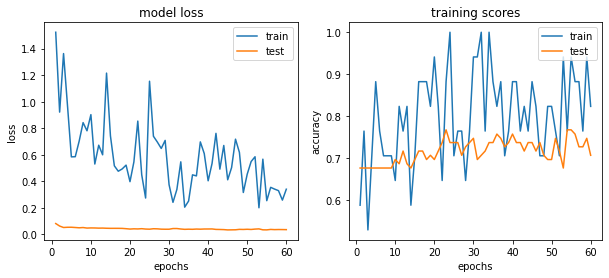

In [121]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, Max_epoch+1), A1)  # train loss (on epoch end)
plt.plot(np.arange(1, Max_epoch+1), C)         #  test loss (on epoch end)
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper right")
# 2nd figure
plt.subplot(122)
plt.plot(np.arange(1, Max_epoch + 1), B1)  # train accuracy (on epoch end)
plt.plot(np.arange(1, Max_epoch + 1), D)         #  test accuracy (on epoch end)
plt.title("training scores")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc="upper right")
plt.show()